In [4]:
import pandas as pd
import numpy as np
from glob import glob
import json
import os
import re
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None)

In [5]:
rows = []
for path in glob("logs/**/*.json"):
    contents = json.loads(open(path).read())
    normalize = {True:'T', False:'F'}[contents.get('normalize', False)]
    mask = {True:"_M", False: ""}[contents.get("mask_input", False)]
    M = ('_'+{'microsoft/phi-2':'phi2', 'gpt2': 'gpt2', 'self_normalize': 'sn', 'self_guidance': 'sg'}[contents['normalizer']]) if normalize == 'T' else ''
    T = {'add': '_ta', 'sub': '_ts', '': ''}[contents.get('normalize_type', '')] if normalize=='T' else ''
    
    dic = {
        "model": path.split("/")[1] + f'_n{normalize}{T}{M}{mask}'
    }
    if 'latest' in path:
        continue
    dic['epoch'] = int(re.search(r"epoch\_([0-9]+)", path).groups(1)[0])
    n = 4 if 'sugar' in path else 1
    dic['dataset'] = '_'.join(os.path.basename(path).split("_")[0:n])
    dic.update(contents)
    rows.append(dic)
df = pd.DataFrame(rows)
df.head()

df['model'].unique(), df['dataset'].unique()


model_last_epoch = df.groupby('model').max().epoch.to_dict()
df['last_epoch'] = df.model.apply(lambda m:model_last_epoch[m])

/tmp/ipykernel_3605/2513039788.py:25: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  model_last_epoch = df.groupby('model').max().epoch.to_dict()


In [6]:
df

,model,epoch,dataset,acc,normalize,normalizer,normalize_type,acc1,acc5,mean_per_class_recall,mask_input,last_epoch
0,datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep50_lr0.0003_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta_phi2,2,sugar_crepe_replace_att,0.736041,True,microsoft/phi-2,add,NaN,NaN,NaN,NaN,5
1,datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep50_lr0.0003_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta_phi2,5,sugar_crepe_replace_obj,0.797216,True,microsoft/phi-2,add,NaN,NaN,NaN,NaN,5
2,datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep50_lr0.0003_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nF,2,sugar_crepe_swap_obj,0.658537,False,microsoft/phi-2,add,NaN,NaN,NaN,NaN,5
3,datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep50_lr0.0003_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta_phi2,2,sugar_crepe_swap_att,0.635135,True,microsoft/phi-2,add,NaN,NaN,NaN,NaN,5
4,datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep50_lr0.0003_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta_phi2,4,sugar_crepe_replace_att,0.739848,True,microsoft/phi-2,add,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...
2019,datacomp_dec_vision_dinov2s14_text_b32_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,1,sugar_crepe_replace_rel,0.665007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
2020,datacomp_dec_vision_dinov2s14_text_b32_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,4,sugar_crepe_replace_rel,0.709104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
2021,datacomp_dec_vision_dinov2s14_text_b32_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta_phi2,2,sugar_crepe_replace_obj,0.747579,True,microsoft/phi-2,add,NaN,NaN,NaN,NaN,4
2022,datacomp_dec_vision_dinov2s14_text_b32_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,4,sugar_crepe_replace_obj,0.756053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


# Leaderboard

In [7]:
df[ (df.dataset=='imagenet1k') & (df.epoch==df.last_epoch)].sort_values(by='acc1', ascending=False)[['model', 'acc1', 'epoch']].round(3)

,model,acc1,epoch
1452,datacomp_dec_vision_dinov2g14_text_b32_locked_image_causal_ep10_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nF,0.671,10
1217,datacomp_dec_vision_dinov2g14_text_b32_locked_image_ep10_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nF,0.628,10
820,datacomp_dec_vision_dinov2l14_text_b32_locked_image_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,0.594,10
1683,datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep10_lr0.0003_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nF,0.548,10
404,datacomp_dec_vision_dinov2s14_text_b32_locked_image_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,0.513,10
1058,datacomp_dec_b32_vision_datacomp_xl_s13b_b90k_text_scratch_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,0.402,10
1540,datacomp_dec_ViT-B-16_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,0.373,10
578,datacomp_dec_ViT-B-32_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,0.321,10
1754,datacomp_dec_ViT-B-32_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs256_nF,0.321,9
2006,datacomp_dec_vision_dinov2s14_text_b32_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,0.318,4


In [8]:
df[ (df.dataset=='sugar_crepe_swap_obj') & (df.epoch==df.last_epoch)].sort_values(by='acc', ascending=False)[['model', 'acc', 'epoch']].round(3)

,model,acc,epoch
1380,datacomp_dec_vision_dinov2g14_text_b32_locked_image_causal_ep10_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nF,0.846,10
1446,datacomp_dec_vision_dinov2g14_text_b32_locked_image_causal_ep10_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ts_phi2,0.833,9
1229,datacomp_dec_vision_dinov2g14_text_b32_locked_image_ep10_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta_phi2,0.780,10
725,datacomp_dec_vision_dinov2g14_text_b32_locked_image_ep50_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta_phi2,0.772,4
1543,datacomp_dec_ViT-B-16_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,0.768,10
273,datacomp_dec_ViT-B-16_ep50_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta_phi2,0.760,14
1135,datacomp_dec_vision_dinov2g14_text_b32_locked_image_null_image_ep10_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta_phi2,0.760,7
741,datacomp_dec_vision_dinov2g14_text_b32_locked_image_ep50_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nF,0.760,4
816,datacomp_dec_vision_dinov2l14_text_b32_locked_image_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta_phi2,0.756,10
1183,datacomp_dec_vision_dinov2g14_text_b32_locked_image_null_image_ep10_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nF,0.752,7


In [9]:
df[ (df.dataset=='sugar_crepe_swap_att') & (df.epoch==df.last_epoch)].sort_values(by='acc', ascending=False)[['model', 'acc', 'epoch']].round(3)

,model,acc,epoch
1397,datacomp_dec_vision_dinov2g14_text_b32_locked_image_causal_ep10_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nF,0.893,10
780,datacomp_dec_vision_dinov2l14_text_b32_locked_image_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta_phi2,0.685,10
1752,datacomp_dec_ViT-B-32_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs256_nT_ta_phi2,0.683,9
710,datacomp_dec_vision_dinov2g14_text_b32_locked_image_ep50_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta_phi2,0.683,4
2001,datacomp_dec_vision_dinov2s14_text_b32_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta_phi2,0.680,4
1954,datacomp_dec_ViT-B-16_ep100_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta_phi2,0.673,3
1004,datacomp_dec_b32_vision_datacomp_xl_s13b_b90k_text_scratch_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta_phi2,0.670,10
513,datacomp_dec_vision_dinov2s14_text_b32_locked_image_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta_phi2,0.670,10
1873,datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep10_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta_phi2,0.670,1
1678,datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep10_lr0.0003_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta_phi2,0.670,10


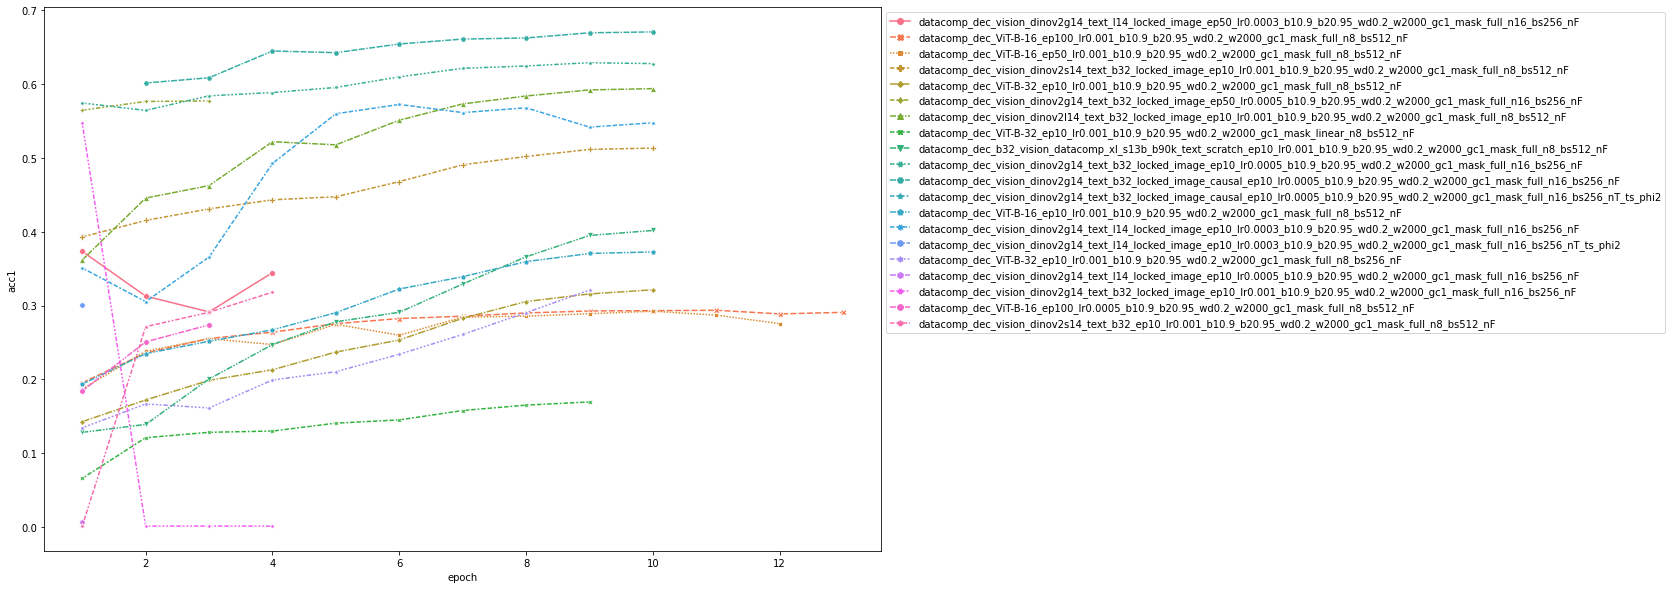

In [10]:
ds = 'imagenet1k'
fig = plt.figure(figsize=(15,10))
sns.lineplot(x='epoch', y='acc1', hue='model', data=df[df.dataset==ds], style='model', markers=True)
plt.legend(loc='best', bbox_to_anchor=(1,1))
plt.show()

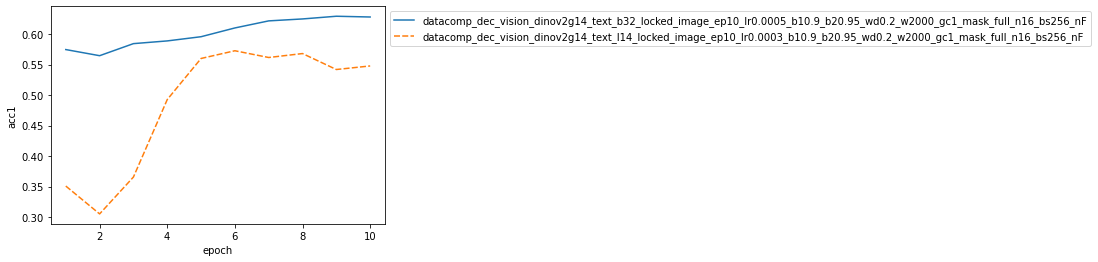

In [11]:
ds = 'imagenet1k'
d = df[df.dataset==ds]
ms = [
'datacomp_dec_vision_dinov2g14_text_b32_locked_image_ep10_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nF',
'datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep10_lr0.0003_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nF',
#'datacomp_dec_vision_dinov2l14_text_b32_locked_image_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF',
#'datacomp_dec_ViT-B-16_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF',
#'datacomp_dec_ViT-B-16_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF',
#'datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep10_lr0.0003_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nF',
]
d = d[d.model.isin(ms)]
sns.lineplot(x='epoch', y='acc1', hue='model', data=d, style='model')
plt.legend(loc='best', bbox_to_anchor=(1,1))
#plt.xticks(np.arange(1, df.epoch.max()+1))
plt.show()

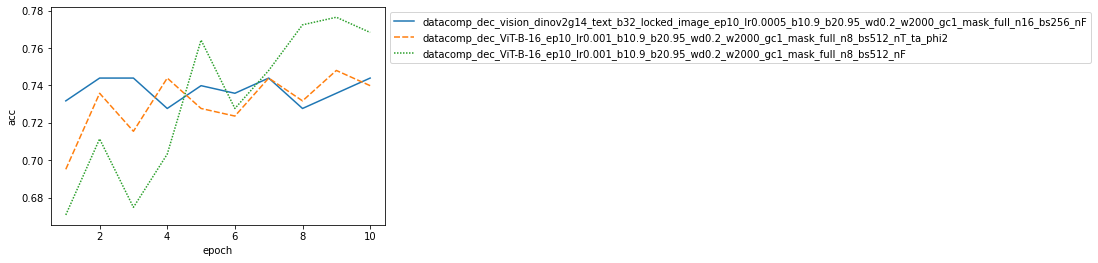

In [12]:
ds = 'sugar_crepe_swap_obj'
d = df[df.dataset==ds]
ms = [
#'datacomp_dec_vision_dinov2g14_text_b32_locked_image_ep10_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta_phi2',
#'datacomp_dec_vision_dinov2g14_text_b32_locked_image_ep10_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta_gpt2',
'datacomp_dec_vision_dinov2g14_text_b32_locked_image_ep10_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nF',

#'datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep10_lr0.0003_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta_phi2',
#'datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep10_lr0.0003_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nF',

#'datacomp_dec_vision_dinov2l14_text_b32_locked_image_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta_phi2',
#'datacomp_dec_vision_dinov2l14_text_b32_locked_image_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF',

'datacomp_dec_ViT-B-16_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta_phi2',
'datacomp_dec_ViT-B-16_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF',
'datacomp_dec_ViT-B-16_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta_phi2',
#'datacomp_dec_ViT-B-16_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF',

#'datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep10_lr0.0003_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta_phi2',
#'datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep10_lr0.0003_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nF',

]
d = d[d.model.isin(ms)]
sns.lineplot(x='epoch', y='acc', hue='model', data=d, style='model')
plt.legend(loc='best', bbox_to_anchor=(1,1))
#plt.xticks(np.arange(1, df.epoch.max()+1))
plt.show()

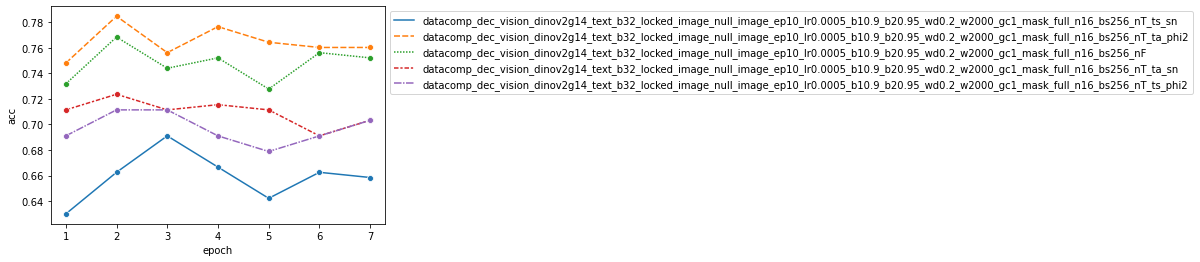

In [14]:
ds = 'sugar_crepe_swap_obj'
d = df[df.dataset==ds]
d = d[d.model.str.contains("datacomp_dec_vision_dinov2g14_text_b32_locked_image_null_image_ep10_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256")]
sns.lineplot(x='epoch', y='acc', hue='model', data=d, style='model', marker='o')
plt.legend(loc='best', bbox_to_anchor=(1,1))
#plt.xticks(np.arange(1, df.epoch.max()+1))
plt.show()

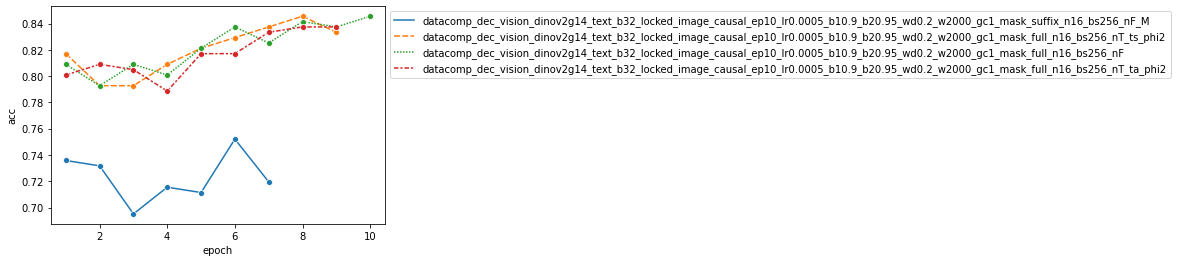

In [17]:
ds = 'sugar_crepe_swap_obj'
d = df[df.dataset==ds]
d = d[d.model.str.contains("causal")]
sns.lineplot(x='epoch', y='acc', hue='model', data=d, style='model', marker='o')
plt.legend(loc='best', bbox_to_anchor=(1,1))
plt.show()

In [339]:
#df[ (df.dataset=='sugar_crepe_swap_obj') & (df.epoch==df.last_epoch)].sort_values(by='acc', ascending=False)[['model', 'acc']].round(3)
d = df[df.epoch==df.last_epoch]
d = d[d.dataset.str.startswith("sugar_crepe")]
d = d.groupby("model")
d = d.filter(lambda n:len(n)==7)
d = d.groupby("model")
d  = d.mean()
d = d.reset_index()
d = d[['model', 'acc', 'epoch']]
d.sort_values(by='acc', ascending=False)

,model,acc,epoch
14,datacomp_dec_vision_dinov2g14_text_b32_locked_image_causal_ep10_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nF,0.909719,10.0
17,datacomp_dec_vision_dinov2g14_text_b32_locked_image_ep50_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta_phi2,0.824755,4.0
15,datacomp_dec_vision_dinov2g14_text_b32_locked_image_ep10_lr0.0005_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta_phi2,0.822106,10.0
21,datacomp_dec_vision_dinov2l14_text_b32_locked_image_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta_phi2,0.821184,10.0
18,datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep10_lr0.0003_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta_phi2,0.815948,10.0
5,datacomp_dec_ViT-B-16_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta_phi2,0.805205,10.0
4,datacomp_dec_ViT-B-16_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nF,0.802685,10.0
6,datacomp_dec_ViT-B-16_ep50_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs512_nT_ta_phi2,0.801689,14.0
8,datacomp_dec_ViT-B-32_ep10_lr0.001_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n8_bs256_nT_ta_phi2,0.800878,9.0
20,datacomp_dec_vision_dinov2g14_text_l14_locked_image_ep50_lr0.0003_b10.9_b20.95_wd0.2_w2000_gc1_mask_full_n16_bs256_nT_ta_phi2,0.799587,5.0
